In [180]:
import pandas as pd
import numpy as np
from scipy.signal import butter, lfilter
from sklearn.decomposition import FastICA
import matplotlib.pyplot as plt
from scipy.stats import kurtosis

from sklearn.preprocessing import MinMaxScaler

In [181]:
keep_channels =['Fp1', 'Fp2', 
                'F7', 'F3', 'Fz', 'F4', 'F8', 
                'FC5', 'FC6', 
                'T7', 'C3', 'C4', 'T8', 
                'CP5', 'CP6',
                'P7', 'P3', 'P4', 'P8', 
                'O1', 'Oz', 'O2']
def get_subject_data(start_series, end_series):
    path = r'C:/Users/tomry/Documents/EEG/train/'
    series = range(start_series, end_series+1)
    subject_data = []
    for serie in series:
        data_filename = path + 'subj1_series%d_data.csv' % serie
        data = pd.read_csv(data_filename)
        data = data.loc[:, keep_channels]
        subject_data.append(data)
    subj_data = pd.concat(subject_data)
    return subj_data.to_numpy()

x = get_subject_data(5, 6)

In [182]:
b, a = butter(4, [0.5, 80], fs=500, btype='bandpass')
x = lfilter(b, a, x, axis=0)
x = x[::3, :]

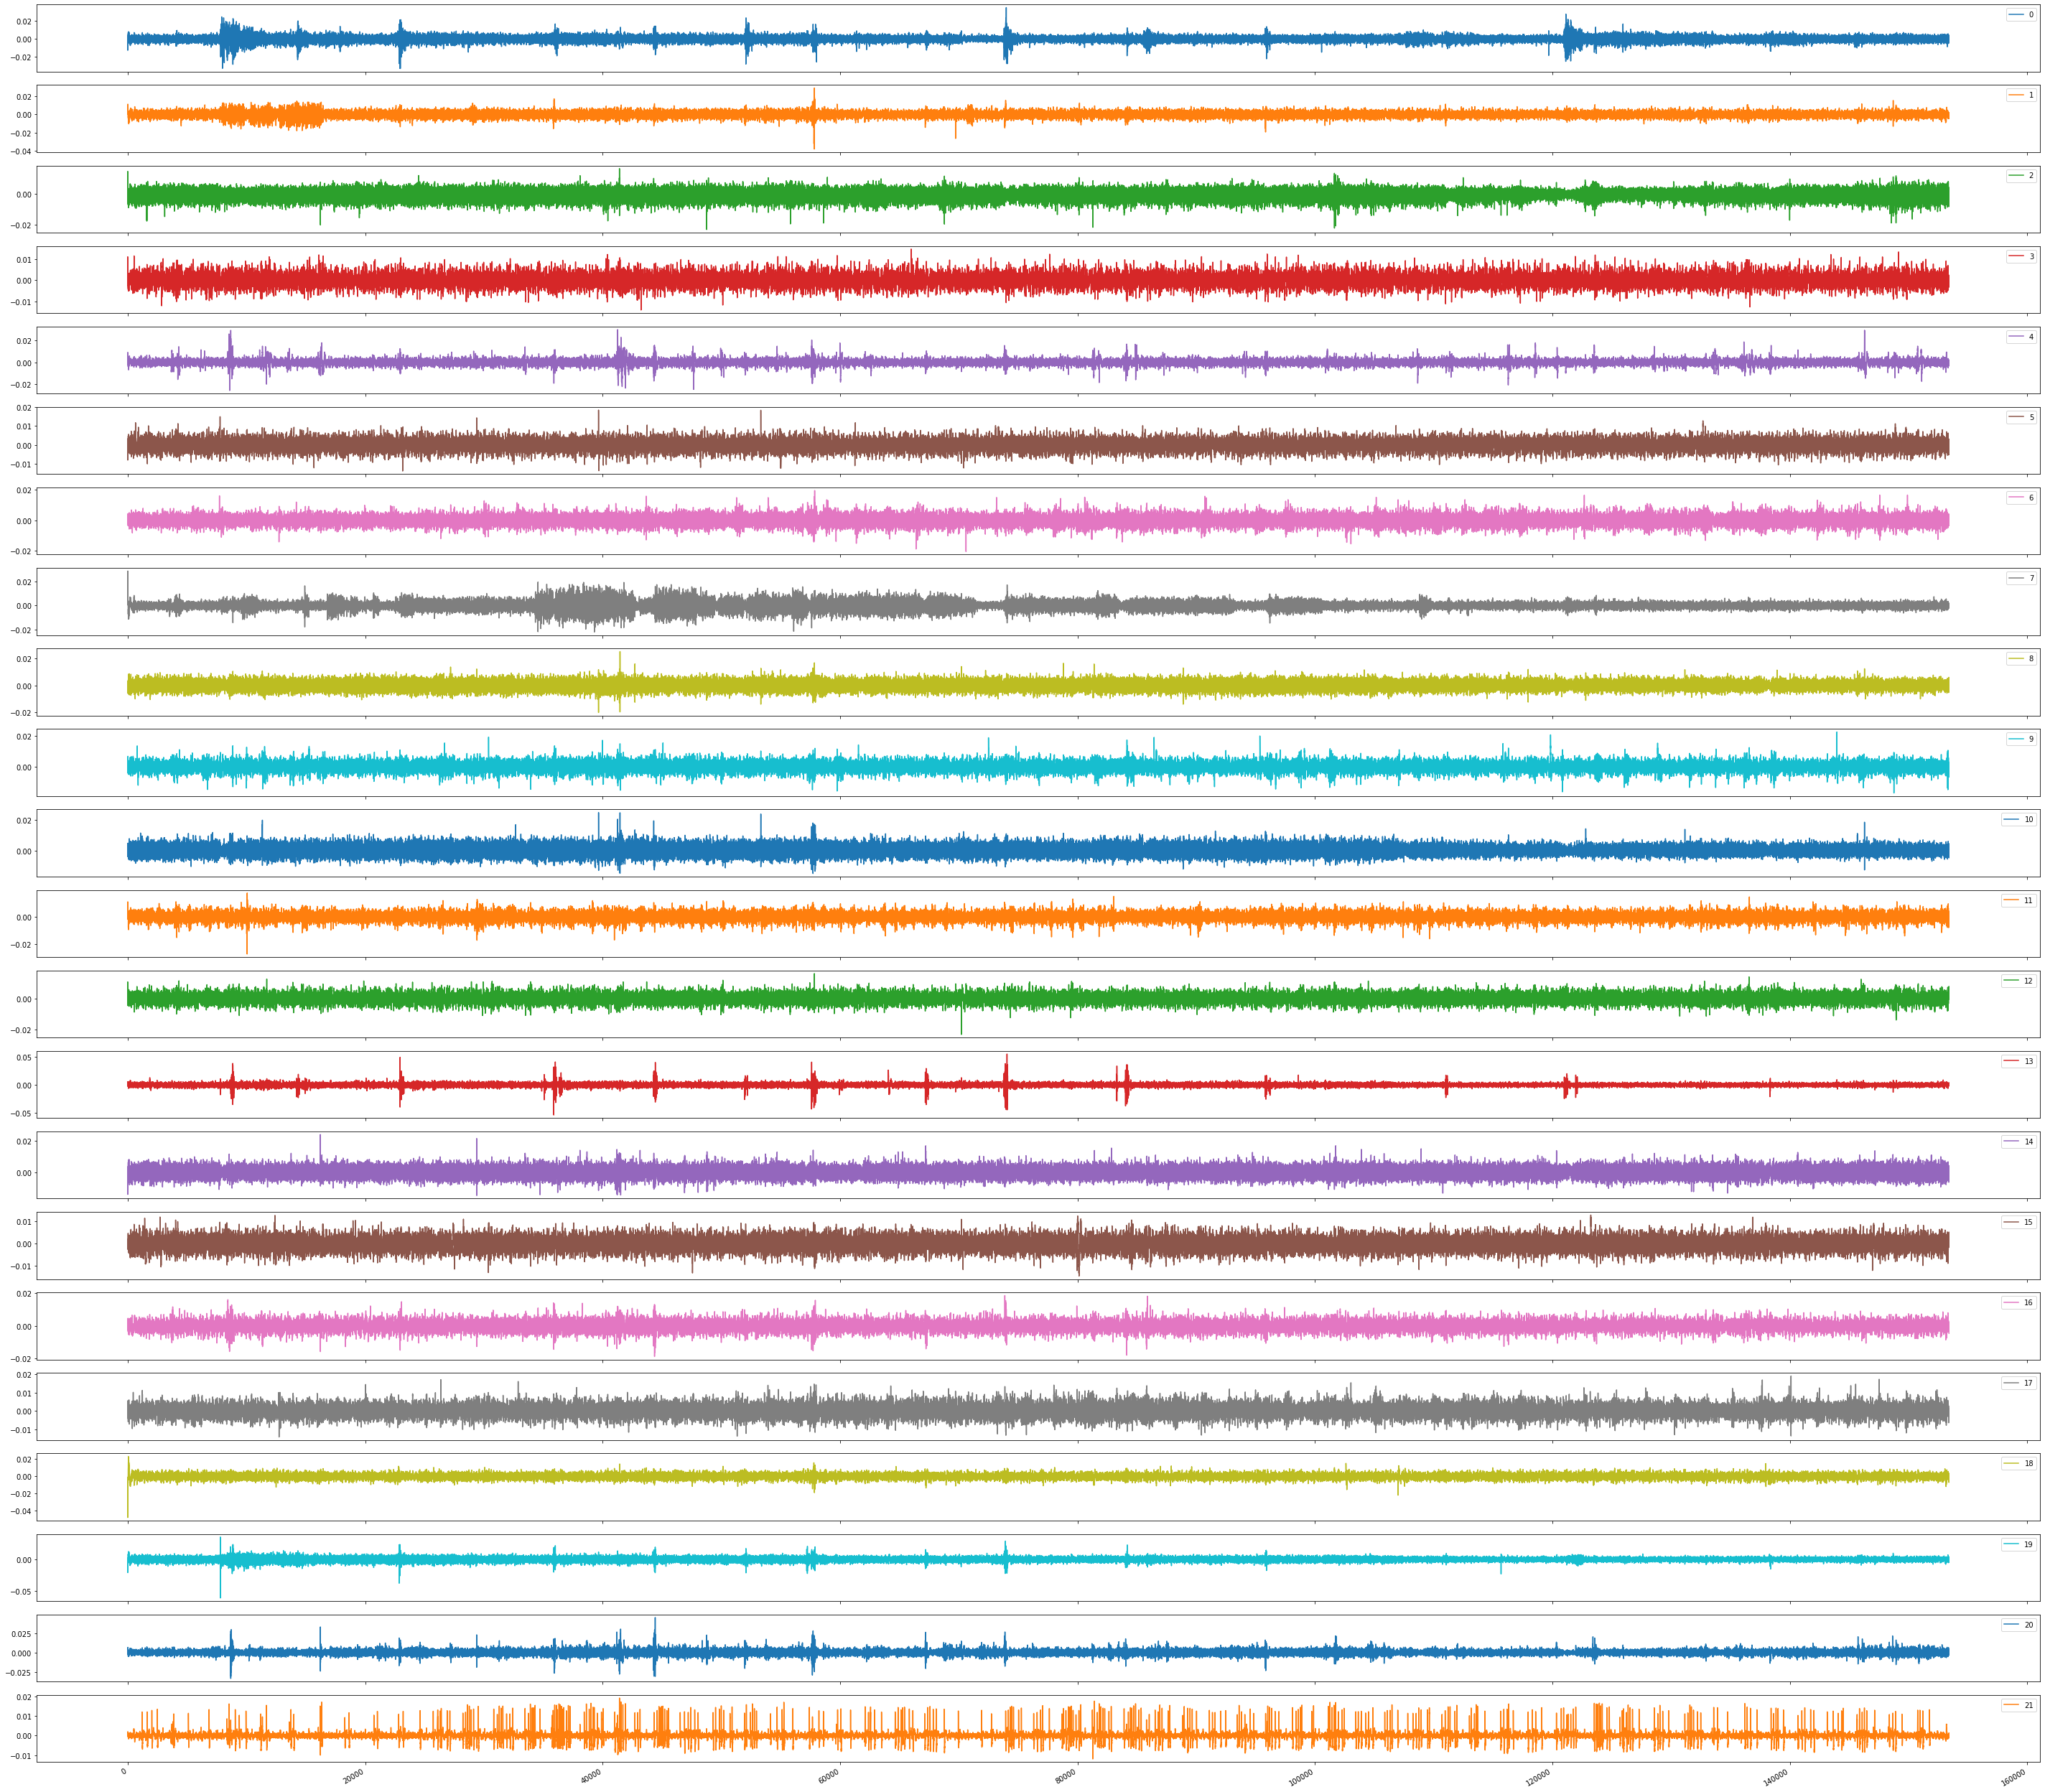

0 94 6.267 1.221
1 82 2.303 1.562
2 150 1.455 1.145
3 58 0.604 1.918
4 81 9.371 2.078
5 34 0.398 1.803
6 115 0.92 1.374
7 166 4.174 1.287
8 58 0.597 1.14
9 103 1.311 1.487
10 91 1.019 1.114
11 90 1.179 1.452
12 45 0.437 1.677
13 68 26.531 1.308
14 88 0.582 1.167
15 33 0.351 1.819
16 68 0.81 1.753
17 105 0.812 1.509
18 42 4.51 1.757
19 93 5.555 1.227
20 129 7.686 1.204
21  - EYEBLINK CHANNEL DETECTED
21 309 9.318 3.675


In [183]:
def hjorth_activity(x):
    ''' Column-wise computation of Hjorth activity (variance). '''
    return np.var(x, axis=0).reshape(1,-1)
     
def hjorth_mobility(x):
    ''' Column-wise computation of Hjorth mobility'''
    return np.sqrt(np.var(np.gradient(x, axis=0), axis=0)/np.var(x, axis=0)).reshape(1,-1)
    
def hjorth_complexity(x):
    ''' Column-wise computation of Hjorth complexity'''
    return hjorth_mobility(np.gradient(x, axis=0)) / hjorth_mobility(x).reshape(1,-1)
    
def detect_blink_peak(x):
    max_val = np.max(np.absolute(x))
    if max_val >= 0.01:
        return True
    else:
        return False
    

ica = FastICA(tol=0.01).fit(x)
x_ica = ica.transform(x) # applies unmixing matrix to x

x_ica_df = pd.DataFrame(data=x_ica)
x_ica_df.plot(subplots=True, figsize=(50,50))
plt.show()

win_length = 200

fs= 500/3

for i, col in enumerate(x_ica.T): # iterate columns
    
    num_blinks = 0
    
    for j in range(0, len(col)-win_length, win_length):
        window = col[j:j+win_length] # window through signal
        is_blink = detect_blink_peak(window) # detect blink in window
        
        # count number of blinks
        if is_blink:
            num_blinks += 1
        
    # compute kurtosis of whole signal
    kur = kurtosis(col)
    
    comp = hjorth_complexity(col)[0][0]
    
    # blink artifact source decision rule
    if num_blinks >= len(x_ica)/(fs*20) and kur > 5 and comp > 3:
        print(i, ' - EYEBLINK CHANNEL DETECTED')
        
    print(i, num_blinks, np.round(kur,3), np.round(comp,3))
    